In [1]:
import sys
sys.path.append('./src/')

import numpy as np
import pandas as pd

from src.benchmarks import Naive2
from src.utils_data import M4_parser

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def plot_single_serie(uid_df, ax):
    """
    uid_df: pandas df
    panel with columns unique_id, ds, y, split
    y_hat_df: pandas df
    panel with columns unique_id, ds, y_hat
    """
    # parse uid_df
    uid_df.reset_index(inplace=True)
    
    # plot last 60 observations
    sns.lineplot(x='ds', y='y', 
                 hue='split', data=uid_df[-60:], ax=ax) #, palette=['#FA6F94','#51DBE6']
    sns.lineplot(x='ds', y='naive', 
             hue='split', data=uid_df[-60:], ax=ax) #, palette=['#FA6F94','#51DBE6']
    
    # rotate x axis
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y')
    ax.set_xlabel('Date Stamp')
    ax.set_ylabel('Value')
    
    # remove legend title
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    
    #sns.lineplot(x='ds', y='y', data=y_df, color='#FA6F94', label='Actual Data')
    #sns.lineplot(x='ds', y='y', data=y_hat_df, color='#51DBE6', label='Forecast Data', )
    #sns.set_style("dark")
    #plt.xlabel("Date Stamp", fontsize=14, color='#A2A2A2')
    #plt.ylabel("Value", fontsize=14, color='#A2A2A2')
    
def plot_grid_series(y, uids):
    assert len(uids)==8
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 7))
    plt.subplots_adjust(wspace=0.35)
    plt.subplots_adjust(hspace=0.4)
    plt.xticks(rotation=45)

    for i, uid in enumerate(uids):
        # single plot parameters
        uid_df = y.loc[uid]
        row = int(np.round(i/8 + 0.001))
        col = i % 4
        
        plot_single_serie(uid_df, ax=axs[row, col])
    
    fig.tight_layout()
    plt.show()
    plot_file = "./results/grid_series.png"
    plt.savefig(plot_file, bbox_inches = "tight", dpi=300)
    plt.close()


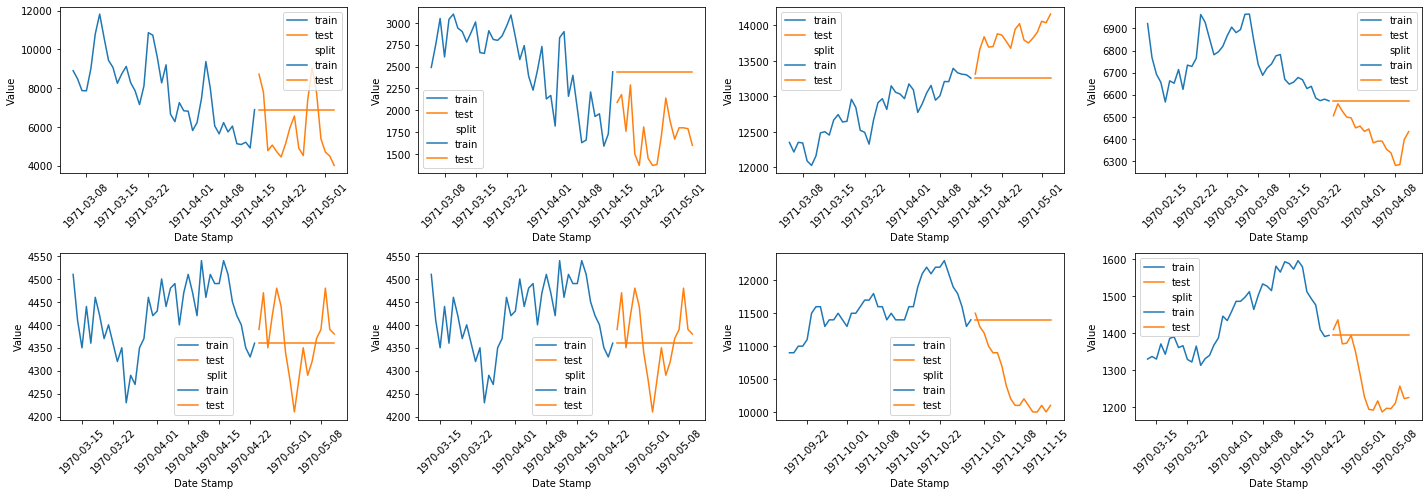

In [3]:
from sklearn.base import BaseEstimator, RegressorMixin, clone


class Naive(BaseEstimator, RegressorMixin):
    """
    Naive model.
    This benchmark model produces a forecast that is equal to
    the last observed value of a given time series.
    """
    def __init__(self, h=1):
        """
        h: int
            forecast horizon, the number of times the last value
            will be repeated
        """
        self.h = h
  
    def fit(self, X, y):
        """
        X: time series covariates (for pipeline compatibility)
        y: train values of the time series
        """
        self.y_hat = [float(y[-1])]
        return self
    
    def predict(self, X):
        """
        X: time series covariates (for pipeline compatibility)
        produces forecast for time horizon 'h' equal to length
        of the covariates.
        """
        if X is not None:
            h = X.shape[0]
        else: 
            h = self.h
        y_hat = np.array(self.y_hat * h)
        return y_hat

    
class PanelModel:
    """
    Panel model class.
    This class inherits an instantiated univariate time series model with 
    fit and predict methods and declares common fit and predict methods
    for full panel data. The panel dataframe is defined by the each series 
    unique_id and their datestamps.
    """
    def __init__(self, model):
        """
        model: sklearn BaseEstimator class
        """
        self.model = model

    def fit(self, X, y):
        """
        X: pandas dataframe
        y: pandas dataframe
        """
        assert X.index.names == ['unique_id', 'ds']
        self.model_ = {}
        for uid, X_uid in X.groupby('unique_id'): 
            y_uid = y.loc[uid]
            self.model_[uid] = clone(self.model)
            self.model_[uid].fit(X_uid.values, y_uid.values)
        return self

    def predict(self, X):
        """
        X: pandas dataframe
        y: pandas dataframe
        """
        idxs, preds = [], []
        for uid, X_uid in X.groupby('unique_id'):
            y_hat_uid = self.model_[uid].predict(X_uid.values)
            idxs.extend(X_uid.index)
            preds.extend(y_hat_uid)
        idx = pd.MultiIndex.from_tuples(idxs, names=('unique_id', 'ds'))
        preds = pd.Series(preds, index=idx)
        return preds

# Read data
X_train_df, y_train_df, X_test_df, y_test_df = M4_parser('Monthly', num_obs=10)

# Pre sort dataframes for efficiency
X_train_df = X_train_df.set_index(['unique_id', 'ds']).sort_index()
y_train_df = y_train_df.set_index(['unique_id', 'ds']).sort_index()
X_test_df = X_test_df.set_index(['unique_id', 'ds']).sort_index()
y_test_df = y_test_df.set_index(['unique_id', 'ds']).sort_index()

# Fit and Predict Naive Model
naive = Naive()
naivePanel = PanelModel(naive)
naivePanel.fit(X_train_df, y_train_df)
naive_predictions = naivePanel.predict(X_test_df)
naive_predictions = naive_predictions.rename('naive')

# Merge for visualization purpose
y_train_df['split'] = 'train'
y_test_df['split'] = 'test'
y_df = y_train_df.append(y_test_df, sort=False)
y_df = y_df.merge(naive_predictions, on=['unique_id','ds'], how='left')

# Grid Plot
uids = ['M1', 'M2', 'M3', 'M4',
        'M5', 'M5', 'M6', 'M8']
plot_grid_series(y_df, uids)